### Reshaping data from long to wide

current data has two rows for each neighborhood. We need to create a new table where each row represents just one unique neighborhood. This table will have separate columns for 2020 and 2024 values.

In [ ]:
import pandas as pd
import numpy as np

print("="*80)
print("RESHAPING PANEL DATA: LONG TO WIDE FORMAT")
print("="*80)

# Load the panel data
df = pd.read_csv('../data/merged_buurt_panel_data_imputed.csv')

print(f"\nOriginal data shape: {df.shape}")
print(f"Years in data: {sorted(df['year'].unique())}")
print(f"Unique neighborhoods: {df['buurtcode_2022'].nunique()}")

# Define columns that stay constant (only need one copy)
constant_cols = [
    'buurtcode_2022',           # Main identifier
    'buurt_cbs_2015',           # CBS codes (constant)
    'buurt_cbs_2022',           # CBS codes (constant)
    'district_type',            # Old buurt name
    'buurt_name',              # New buurt name (post-2022)
    'wijk_name',               # Wijk name
    'stadsdeel_name',          # Stadsdeel name
    'municipality_name',       # Municipality
    'buurt_area_m2'           # Area in m2
]

# Define columns that vary by year (need 2020 and 2024 versions)
varying_cols = [
    # Demographics
    'population_total',
    'pop_age_0_15',
    'pop_age_15_25', 
    'pop_age_25_45',
    'pop_age_45_65',
    'pop_age_65_plus',
    'avg_household_size',
    
    # Housing
    'woz_value',
    'pct_unoccupied',
    'pct_owner_occupied',
    'pct_rental',
    
    # Income & Socioeconomic
    'n_high_education',
    'income_recipient',
    'income_inhabitant',
    'income_household',
    'pct_bottom40',
    'pct_top20',
    'pct_low_income',
    'pct_below_120pct_social_min',
    
    # Urbanicity (can change over time)
    'urbanicity',
    
    # Facilities
    'supermarkets_1km',
    'food_shops_1km',
    'cafes_1km',
    'cafeterias_1km',
    'restaurants_1km',
    'dist_primary_school',
    'dist_secondary_school',
    'dist_train_station',
    
    # Green metrics
    'dist_nearest_green_2020',
    'nearest_green_name_2020',
    'nearest_green_type_2020',
    'nearest_green_area_m2_2020',
    'total_green_area_m2_2020',
    'green_coverage_pct_2020',
    'num_green_spaces_2020',
    'dist_nearest_green_2024',
    'nearest_green_name_2024',
    'nearest_green_type_2024',
    'nearest_green_area_m2_2024',
    'total_green_area_m2_2024',
    'green_coverage_pct_2024',
    'num_green_spaces_2024'
]

print(f"\nConstant columns (1 copy per buurt): {len(constant_cols)}")
print(f"Varying columns (2020 & 2024 versions): {len(varying_cols)}")

# Split data by year
df_2020 = df[df['year'] == 2020].copy()
df_2024 = df[df['year'] == 2024].copy()

print(f"\n2020 rows: {len(df_2020)}")
print(f"2024 rows: {len(df_2024)}")

# Start with constant columns from 2020 data (could use 2024, doesn't matter)
wide_df = df_2020[constant_cols].copy()

# Add 2020 varying columns with _2020 suffix
for col in varying_cols:
    if col in df_2020.columns:
        # For green columns with _2020 suffix, add directly
        if col.endswith('_2020'):
            wide_df[col] = df_2020[col].values
        # Skip _2024 columns (don't exist in 2020 data)
        elif col.endswith('_2024'):
            continue
        # For other columns, add with _2020 suffix
        else:
            wide_df[f'{col}_2020'] = df_2020[col].values

# Merge 2024 varying columns with _2024 suffix
for col in varying_cols:
    if col in df_2024.columns:
        # For green columns with _2024 suffix, add from 2024 data
        if col.endswith('_2024'):
            mapping = dict(zip(df_2024['buurtcode_2022'], df_2024[col]))
            wide_df[col] = wide_df['buurtcode_2022'].map(mapping)
        # Skip _2020 columns (already added)
        elif col.endswith('_2020'):
            continue
        # For other columns, add with _2024 suffix
        else:
            mapping = dict(zip(df_2024['buurtcode_2022'], df_2024[col]))
            wide_df[f'{col}_2024'] = wide_df['buurtcode_2022'].map(mapping)

# Calculate change variables (useful for modeling)
change_vars = {
    'population_change': ('population_total_2024', 'population_total_2020'),
    'woz_change': ('woz_value_2024', 'woz_value_2020'),
    'income_household_change': ('income_household_2024', 'income_household_2020'),
    'pct_bottom40_change': ('pct_bottom40_2024', 'pct_bottom40_2020'),
    'pct_top20_change': ('pct_top20_2024', 'pct_top20_2020'),
    'pct_low_income_change': ('pct_low_income_2024', 'pct_low_income_2020'),
    'green_coverage_change': ('green_coverage_pct_2024', 'green_coverage_pct_2020'),
    'dist_green_change': ('dist_nearest_green_2024', 'dist_nearest_green_2020'),
    'n_high_education_change': ('n_high_education_2024', 'n_high_education_2020'),
}

print(f"\nCalculating change variables...")
for change_name, (col_2024, col_2020) in change_vars.items():
    if col_2024 in wide_df.columns and col_2020 in wide_df.columns:
        wide_df[change_name] = wide_df[col_2024] - wide_df[col_2020]
        print(f"  ✓ {change_name}")

# Reorder columns for better readability
# Order: identifiers -> constant info -> 2020 vars -> 2024 vars -> change vars
id_cols = ['buurtcode_2022', 'buurt_cbs_2015', 'buurt_cbs_2022']
name_cols = ['district_type', 'buurt_name', 'wijk_name', 'stadsdeel_name', 'municipality_name']
area_cols = ['buurt_area_m2']
cols_2020 = [c for c in wide_df.columns if c.endswith('_2020')]
cols_2024 = [c for c in wide_df.columns if c.endswith('_2024')]
change_cols = [c for c in wide_df.columns if c.endswith('_change')]

# Combine in order
ordered_cols = id_cols + name_cols + area_cols + cols_2020 + cols_2024 + change_cols
wide_df = wide_df[ordered_cols]

# Save to CSV
output_file = '../data/buurt_data_wide_format.csv'
wide_df.to_csv(output_file, index=False)

print(f"\n{'='*80}")
print("TRANSFORMATION COMPLETE")
print(f"{'='*80}")
print(f"\nOutput shape: {wide_df.shape}")
print(f"  Rows (unique buurten): {len(wide_df)}")
print(f"  Columns: {len(wide_df.columns)}")

print(f"\nColumn breakdown:")
print(f"  Identifiers: {len(id_cols)}")
print(f"  Names/metadata: {len(name_cols + area_cols)}")
print(f"  2020 variables: {len(cols_2020)}")
print(f"  2024 variables: {len(cols_2024)}")
print(f"  Change variables: {len(change_cols)}")

print(f"\n✓ Saved to: {output_file}")

# Show sample
print(f"\nSample columns (first 15):")
for i, col in enumerate(wide_df.columns[:15], 1):
    print(f"  {i:2d}. {col}")

print(f"\nSample data (first 3 rows):")
sample_cols = [
    'buurtcode_2022', 'buurt_name', 
    'population_total_2020', 'population_total_2024', 'population_change',
    'woz_value_2020', 'woz_value_2024', 'woz_change',
    'green_coverage_pct_2020', 'green_coverage_pct_2024', 'green_coverage_change'
]
available_sample_cols = [c for c in sample_cols if c in wide_df.columns]
print(wide_df[available_sample_cols].head(3).to_string(index=False))

# Data quality check
print(f"\n{'='*80}")
print("DATA QUALITY CHECK")
print(f"{'='*80}")
print(f"\nMissing values by column (top 10):")
missing_counts = wide_df.isnull().sum()
missing_pct = (missing_counts / len(wide_df) * 100).round(1)
missing_df = pd.DataFrame({
    'Missing': missing_counts[missing_counts > 0],
    'Percent': missing_pct[missing_counts > 0]
}).sort_values('Missing', ascending=False).head(10)

if len(missing_df) > 0:
    print(missing_df.to_string())
else:
    print("  No missing values!")

print(f"\nNext steps:")
print(f"  1. Define target variable (e.g., gentrification indicator)")
print(f"  2. Select features (exclude identifiers and names)")
print(f"  3. Train Random Forest classifier")

RESHAPING PANEL DATA: LONG TO WIDE FORMAT

Original data shape: (878, 56)
Years in data: [np.int64(2020), np.int64(2024)]
Unique neighborhoods: 439

Constant columns (1 copy per buurt): 9
Varying columns (2020 & 2024 versions): 42

2020 rows: 439
2024 rows: 439

Calculating change variables...
  ✓ population_change
  ✓ woz_change
  ✓ income_household_change
  ✓ pct_bottom40_change
  ✓ pct_top20_change
  ✓ pct_low_income_change
  ✓ green_coverage_change
  ✓ dist_green_change
  ✓ n_high_education_change

TRANSFORMATION COMPLETE

Output shape: (439, 88)
  Rows (unique buurten): 439
  Columns: 88

Column breakdown:
  Identifiers: 3
  Names/metadata: 6
  2020 variables: 35
  2024 variables: 35
  Change variables: 9

✓ Saved to: buurt_data_wide_format.csv

Sample columns (first 15):
   1. buurtcode_2022
   2. buurt_cbs_2015
   3. buurt_cbs_2022
   4. district_type
   5. buurt_name
   6. wijk_name
   7. stadsdeel_name
   8. municipality_name
   9. buurt_area_m2
  10. population_total_2020
  1

In [ ]:
# Load the wide-format data you created
df_wide = pd.read_csv('../data/buurt_data_wide_format.csv')

# --- Step 1: Stricter Baseline Filtering ---
median_income_2020 = df_wide['income_household_2020'].median()
median_woz_2020 = df_wide['woz_value_2020'].median()

# A buurt is eligible if it was below the median on BOTH key metrics
df_wide['is_eligible'] = (
    (df_wide['income_household_2020'] < median_income_2020) &
    (df_wide['woz_value_2020'] < median_woz_2020)
).astype(int)

# --- Step 2: Stricter Upgrading Criteria ---
df_wide['woz_growth_pct'] = (df_wide['woz_value_2024'] - df_wide['woz_value_2020']) / df_wide['woz_value_2020']
df_wide['income_growth_pct'] = (df_wide['income_household_2024'] - df_wide['income_household_2020']) / df_wide['income_household_2020']
df_wide['education_growth_abs'] = df_wide['n_high_education_2024'] - df_wide['n_high_education_2020']

# Calculate the 75th percentile (top quartile) for growth rates
top_quartile_woz_growth = df_wide['woz_growth_pct'].quantile(0.75)
top_quartile_income_growth = df_wide['income_growth_pct'].quantile(0.75)
top_quartile_education_growth = df_wide['education_growth_abs'].quantile(0.75)

# Check if a buurt's growth was in the top 25% for each indicator
criteria_woz = (df_wide['woz_growth_pct'] > top_quartile_woz_growth).astype(int)
criteria_income = (df_wide['income_growth_pct'] > top_quartile_income_growth).astype(int)
criteria_edu = (df_wide['education_growth_abs'] > top_quartile_education_growth).astype(int)

# Count how many rapid upgrading criteria each buurt meets
df_wide['upgrading_criteria_met'] = criteria_woz + criteria_income + criteria_edu

# --- Step 3: Create the Final, Stricter Gentrification Flag ---
df_wide['gentrified'] = (
    (df_wide['is_eligible'] == 1) &
    (df_wide['upgrading_criteria_met'] >= 2)
).astype(int)

# --- Step 4: Save the NEW, CORRECTED Dataset ---
output_file = '../data/buurt_data_for_modeling_STRICT.csv'
df_wide.to_csv(output_file, index=False)
print(f"\n✓ Final dataset with STRICT gentrification flag saved to: {output_file}")


# ============================================================================
# NOW, RUN THE PROFILING ON THE CORRECT DATAFRAME (`df_wide`)
# ============================================================================

print("\n" + "#"*80)
print("# DETAILED PROFILING OF **STRICT** GENTRIFICATION FLAG")
print("#"*80)

# --- SECTION 0: SUMMARY OF THE NEW FLAG ---
gentrified_count = df_wide['gentrified'].sum()
total_buurten = len(df_wide)
gentrified_pct = (gentrified_count / total_buurten) * 100
print(f"\nNumber of gentrified neighborhoods: {gentrified_count} out of {total_buurten} ({gentrified_pct:.1f}%)")


# --- SECTION 1: BASELINE CHARACTERISTICS (2020) ---
print("\n" + "="*80)
print("SECTION 1: BASELINE CHARACTERISTICS (2020)")
print("="*80)

baseline_vars = [
    'woz_value_2020', 'income_household_2020', 'n_high_education_2020',
    'pct_rental_2020', 'pct_bottom40_2020', 'green_coverage_pct_2020'
]
baseline_profile = df_wide.groupby('gentrified')[baseline_vars].mean()
print("\n", baseline_profile.round(2).to_string())

# --- SECTION 2: TRANSFORMATION METRICS (CHANGE FROM 2020-2024) ---
print("\n" + "="*80)
print("SECTION 2: TRANSFORMATION METRICS (CHANGE FROM 2020-2024)")
print("="*80)

change_vars = [
    'woz_change', 'income_household_change', 'population_change',
    'pct_bottom40_change', 'pct_top20_change', 'green_coverage_change'
]
change_profile = df_wide.groupby('gentrified')[change_vars].mean()
print("\n", change_profile.round(2).to_string())

# --- SECTION 3: GEOGRAPHIC DISTRIBUTION ---
print("\n" + "="*80)
print("SECTION 3: GEOGRAPHIC DISTRIBUTION BY STADSDEEL (CITY DISTRICT)")
print("="*80)

geo_dist = pd.crosstab(df_wide['stadsdeel_name'], df_wide['gentrified'])
geo_dist['Total Buurten'] = geo_dist.get(0, 0) + geo_dist.get(1, 0)
geo_dist['Percent Gentrified'] = (geo_dist.get(1, 0) / geo_dist['Total Buurten'] * 100).round(1)
geo_dist.rename(columns={0: 'Non-Gentrified', 1: 'Gentrified'}, inplace=True)
print("\n", geo_dist.sort_values('Percent Gentrified', ascending=False).to_string())




✓ Final dataset with STRICT gentrification flag saved to: buurt_data_for_modeling_STRICT.csv

################################################################################
# DETAILED PROFILING OF **STRICT** GENTRIFICATION FLAG
################################################################################

Number of gentrified neighborhoods: 49 out of 439 (11.2%)

SECTION 1: BASELINE CHARACTERISTICS (2020)

             woz_value_2020  income_household_2020  n_high_education_2020  pct_rental_2020  pct_bottom40_2020  green_coverage_pct_2020
gentrified                                                                                                                           
0                   523.44                  36.31                 754.56            63.47              47.78                     9.26
1                   257.86                  23.60                 596.64            81.94              65.31                    11.25

SECTION 2: TRANSFORMATION METRICS (CHANGE FROM

### train the Random Forest Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# ============================================================================
# PART 1: SETUP - LOAD DATA AND DEFINE X AND Y
# ============================================================================

# Load your final, validated dataset
df = pd.read_csv('../data/buurt_data_for_modeling_STRICT.csv')

# Define your target variable (Y)
target = 'gentrified'
y = df[target]

# Define your features (X) - these are the conditions in 2020
# This line automatically includes 'urbanicity_2020'
features = [col for col in df.columns if col.endswith('_2020')]
# Also add the constant 'buurt_area_m2' feature
features.append('buurt_area_m2')

# <<< CHANGE: Define non-numeric text columns to exclude
exclude_cols = ['nearest_green_name_2020', 'nearest_green_type_2020']

# <<< CHANGE: Filter out the excluded columns from the feature list
features = [f for f in features if f not in exclude_cols]

X = df[features]

print(f"Target variable: '{target}'")
print(f"Number of features: {len(features)}")
print(f"Feature examples: {features[:5]}")


# ============================================================================
# PART 2: SPLIT DATA FOR TRAINING AND TESTING
# ============================================================================

# Split the data into 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,     # 20% of data will be held back for testing
    random_state=42,   # Ensures the split is the same every time you run it
    stratify=y         # Ensures the proportion of gentrified/non-gentrified is the same in train and test sets
)

print(f"\nTraining set size: {len(X_train)} neighborhoods")
print(f"Testing set size:  {len(X_test)} neighborhoods")



Target variable: 'gentrified'
Number of features: 34
Feature examples: ['population_total_2020', 'pop_age_0_15_2020', 'pop_age_15_25_2020', 'pop_age_25_45_2020', 'pop_age_45_65_2020']

Training set size: 351 neighborhoods
Testing set size:  88 neighborhoods


In [7]:
from sklearn.model_selection import GridSearchCV

# ============================================================================
# PART 3 (REVISED): EXTENSIVE GRID SEARCH
# ============================================================================

# Define a more extensive grid of parameters to test
param_grid = {
    'n_estimators': [100, 200, 300, 400],           # More options for number of trees
    'max_features': ['sqrt', 'log2', 0.8],          # How many features to consider at each split
    'max_depth': [10, 20, 30, None],                # Deeper trees
    'min_samples_split': [2, 5, 10],                # More options for splitting nodes
    'min_samples_leaf': [1, 2, 4]                   # Controls the size of the final leaves
}

# Initialize the model
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Initialize GridSearchCV
# Scoring on 'f1' is crucial because it balances precision and recall for your minority class
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1', verbose=2)

# Train the model using the grid search (verbose=2 will show you progress)
print("\nPerforming MORE EXTENSIVE Grid Search for best parameters...")
grid_search.fit(X_train, y_train)
print("...Grid Search complete.")

# Get the best model found by the search
best_rf_model = grid_search.best_estimator_

print(f"\nBest parameters found: {grid_search.best_params_}")




Performing MORE EXTENSIVE Grid Search for best parameters...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
...Grid Search complete.

Best parameters found: {'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}


In [8]:
# ============================================================================
# PART 4: EVALUATE THE MODEL'S PERFORMANCE
# ============================================================================

# Make predictions on the unseen test data
y_pred = best_rf_model.predict(X_test)

print("\n" + "="*80)
print("MODEL PERFORMANCE ON UNSEEN TEST DATA")
print("="*80)

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nOverall Accuracy: {accuracy:.2%}")

# Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Gentrified (0)', 'Gentrified (1)']))


# ============================================================================
# PART 5: INTERPRET THE MODEL WITH FEATURE IMPORTANCE
# ============================================================================

# Extract the feature importances from the trained model
importances = best_rf_model.feature_importances_

# Create a DataFrame to view the results
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n" + "="*80)
print("TOP 15 MOST IMPORTANT PREDICTORS OF GENTRIFICATION RISK")
print("="*80)
print(feature_importance_df.head(15).to_string(index=False))


MODEL PERFORMANCE ON UNSEEN TEST DATA

Overall Accuracy: 86.36%

Classification Report:
                    precision    recall  f1-score   support

Non-Gentrified (0)       0.93      0.91      0.92        78
    Gentrified (1)       0.42      0.50      0.45        10

          accuracy                           0.86        88
         macro avg       0.68      0.71      0.69        88
      weighted avg       0.88      0.86      0.87        88


TOP 15 MOST IMPORTANT PREDICTORS OF GENTRIFICATION RISK
                 Feature  Importance
          woz_value_2020    0.436795
   income_recipient_2020    0.175879
      pop_age_15_25_2020    0.051380
   supermarkets_1km_2020    0.045668
   income_household_2020    0.038578
      pop_age_25_45_2020    0.029379
  income_inhabitant_2020    0.024944
total_green_area_m2_2020    0.024765
 dist_nearest_green_2020    0.014171
   n_high_education_2020    0.013690
     food_shops_1km_2020    0.013352
       pct_bottom40_2020    0.010452
    pop_ag

Text(0.5, 0, 'Feature Importance')

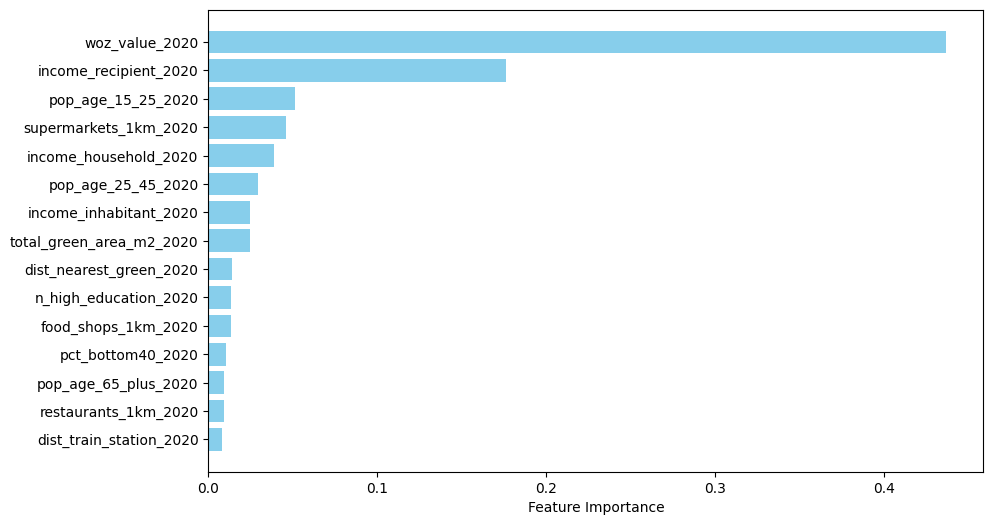

In [ ]:
# create a bar plot of the top 15 features
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'].head(15)[::-1], feature_importance_df['Importance'].head(15)[::-1], color='skyblue')
plt.xlabel('Feature Importance')
plt.savefig("../results/feature_importance.png", dpi=300, bbox_inches='tight')